In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import numpy as np
import pymoo

from pymoo.model.problem import FunctionalProblem
from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.factory import get_crossover, get_mutation, get_sampling
from pymoo.optimize import minimize
from pymoo.problems.single.knapsack import create_random_knapsack_problem
from pymoo.model.problem import Problem
from collections import Counter
from scipy.ndimage.measurements import label
from operator import itemgetter
from pymoo.model.problem import ConstraintsAsPenaltyProblem
from scipy.ndimage import binary_fill_holes
from functionfile import *

In [3]:
def initial_guess(nelx,nely,lx,ly):
    nodecoord=coordinates(nelx,nely,lx,ly)  #specify nelx,nely,lx and ly(in this order)


    nodecon = connectivity(nelx,nely)     #specify nelx,nely

    numnode = np.size(nodecoord,0)
    numele = np.size(nodecon,0)

    xmax=np.squeeze(np.where(nodecoord[:,1]==np.amax(nodecoord[:,1])))
    xmin=np.squeeze(np.where(nodecoord[:,1]==np.amin(nodecoord[:,1])))
    ymax=np.squeeze(np.where(nodecoord[:,2]==np.amax(nodecoord[:,2])))
    ymin=np.squeeze(np.where(nodecoord[:,2]==np.amin(nodecoord[:,2])))
    centerline=np.squeeze(np.where(nodecoord[:,2]==0))

    symmetry_bc=rownum(ymax+1)


    fixed_nodes=fixed(nelx,nely)    #specify nelx,nely
    # knowndof=np.hstack((2*fixed_nodes-2,2*fixed_nodes-1))
    knowndof=rownum(fixed_nodes)
    # activedof=np.empty([2*numnode-len(knowndof),1])
    knowndof=np.append(knowndof,symmetry_bc[::2])
    activedof=np.setdiff1d(np.arange(0,2*numnode),knowndof)


    E1=1
    E2=2

    nu1=0.3
    nu2=0.3

    C1=np.array([[1, nu1, 0], [nu1, 1, 0], [0, 0, (1-nu1)/2]])*(E1/(1-nu1**2))
    C2=np.array([[1, nu2, 0], [nu2, 1, 0], [0, 0, (1-nu2)/2]])*(E2/(1-nu2**2))

    r,c=dimension(nodecoord)
    matnum=np.empty((numele,1)).astype('int')
    matnum[0:r*c//2]=0       #here in place of 200 add half of nelx*nely
    matnum[r*c//2:r*c]=1

    nodecon=np.hstack((nodecon,matnum))

    kg=np.zeros((numnode*2,numnode*2))
    fg=np.zeros((numnode*2,1))

    for i in range(numele):
        nodes = nodecon[i,1:5]
        xi = nodecoord[nodes-1,1]
        yi = nodecoord[nodes-1,2]

        rn = np.empty([8,1])
        rn = rownum(nodes)

        if (nodecon[i,5]==0):
            Ke,Bint,A = stiffness(C1,xi,yi)
        else:
            Ke,Bint,A = stiffness(C2,xi,yi)

        Ke=Ke*0.05
        kg[rn.T,rn] = kg[rn.T,rn] + Ke

    load_point=nodecoord[-1,0]  #specify nelx,nely

    fg[2*load_point.astype('int')-1] = -1

    d=np.zeros([2*numnode])

    # =============================================================================
    # kgr=kg
    # fgr=fg
    # 
    # kgr=np.delete(kgr,knowndof,0)
    # kgr=np.delete(kgr,knowndof,1)
    # 
    # fgr=np.delete(fgr,knowndof,0)
    # 
    # d[activedof]=np.linalg.solve(kgr,fgr)
    # =============================================================================

    d[activedof]=np.linalg.solve(kg[activedof[:,None],activedof[:,None].T],fg[activedof]).reshape(-1)

    w=d[2*ymax+1]

    fig1=plt.figure()
    plt.plot((nodecoord[ymax,1]),w)
    plt.show()

    fig2=plt.figure()
    ax2=plt.gca()

    patches = []
    cm_Sxx=np.empty([numele,])
    cm_Exx=np.empty([numele,])

    for i in range(numele):
        nodes = nodecon[i,1:5]
        xi = nodecoord[nodes-1,1]
        yi = nodecoord[nodes-1,2]

        if (nodecon[i,5]==0):
           Ke,Bint,A = stiffness(C1,xi,yi)
        else:
           Ke,Bint,A = stiffness(C2,xi,yi)

        rn = rownum(nodes)
        strain=np.linalg.multi_dot([Bint,d[rn.reshape(-1)]])/A

        if (nodecon[i,5]==0):
           stress=np.linalg.multi_dot([C1,strain])
        else:
           stress=np.linalg.multi_dot([C2,strain])

        xy=np.vstack((xi,yi)).T

        k = Polygon(xy,closed=True,edgecolor='k')
        patches.append(k)
        cm_Sxx[i]=stress[0]
        cm_Exx[i]=strain[0]

    p = PatchCollection(patches, cmap='jet', match_original=True)
    p.set_array(cm_Sxx)

    ax2.add_collection(p)
    plt.xlim([0,2])
    plt.ylim([-0.25,0.25])

    # divider = make_axes_locatable(ax2)
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    fig2.colorbar(p,ax=ax2)

    plt.show()


    # =============================================================================
    # i=0
    # nodes = nodecon[i,1:5]
    # xi = nodecoord[nodes-1,1]
    # yi = nodecoord[nodes-1,2]
    #     
    # Ke,Bint,A = stiffness(C,xi,yi)
    # rn = rownum(nodes)
    # strain=np.linalg.multi_dot([Bint,d[rn.reshape(-1)]])/A
    # stress=np.linalg.multi_dot([C,strain])
    # =============================================================================


    # =============================================================================
    # fig = plt.figure()
    # ax = plt.axes(projection ="3d")
    # 
    # ax.scatter3D(nodecoord[:,1],nodecoord[:,2],d[1:2*numnode:2])
    # =============================================================================


    # =============================================================================
    # nodes = nodecon[i,1:5]
    # xi = nodecoord[nodes-1,1]
    # yi = nodecoord[nodes-1,2]
    # 
    # rn = np.empty([8,1],dtype=int)
    # rn = rownum(nodes)
    # 
    # dele=d[rn.reshape(-1)]
    # strain=np.linalg.multi_dot([Bint,dele])/A
    # =============================================================================



    # =============================================================================
    # import numpy as np
    # import pandas as pd
    # import matplotlib.pyplot as plt
    # from matplotlib.patches import Polygon,Rectangle
    # 
    # xy=np.array([[0,0],[1,1],[2,3],[0,1]])
    # 
    # 
    # # xy=np.array([[0,0],[2,0],[2,5]])
    # 
    # fig=plt.figure()
    # ax=plt.gca()
    # 
    # k = Polygon(xy,closed=True,facecolor='none',edgecolor='k')
    # # k=Rectangle((0,0),1,1)
    # 
    # ax.add_patch(k)
    # 
    # cm=np.array([[5,3],[0,1]])
    # 
    # im=plt.imshow(cm,'jet',interpolation='bilinear',clip_path=k, clip_on=True,origin='lower',extent=[0,2,0,3])
    # im.set_clip_path(k)
    # 
    # # im=plt.imshow(cm,'jet',interpolation='bilinear',origin='lower',extent=[0,2,0,3])
    # 
    # 
    # plt.xlim([0,3])
    # plt.ylim([0,6])
    # plt.colorbar()
    # plt.show()
    # 
    # xx=np.arange(0,10,0.01)
    # yy=xx*np.exp(-xx)
    # dubba=xx.reshape(yy.size,1)
    # =============================================================================




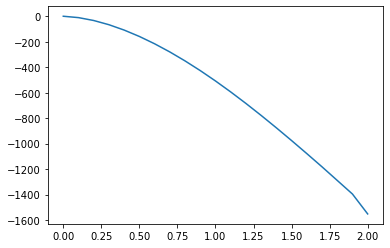

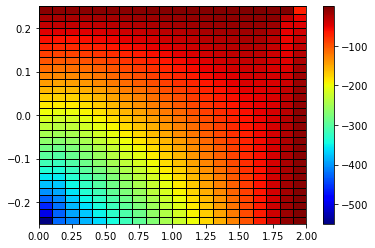

In [4]:
initial_guess(20,30,2,0.5)

In [5]:
from pymoo.util.termination.default import SingleObjectiveDefaultTermination

In [6]:
def TopOpt(nelx,nely,lx,ly,n_gen,E,nu):
    nodecoord=coordinates(nelx,nely,lx,ly)  #specify nelx,nely,lx and ly(in this order)


    nodecon = connectivity(nelx,nely)     #specify nelx,nely

    numnode = np.size(nodecoord,0)
    numele = np.size(nodecon,0)

    xmax=np.squeeze(np.where(nodecoord[:,1]==np.amax(nodecoord[:,1])))
    xmin=np.squeeze(np.where(nodecoord[:,1]==np.amin(nodecoord[:,1])))
    ymax=np.squeeze(np.where(nodecoord[:,2]==np.amax(nodecoord[:,2])))
    ymin=np.squeeze(np.where(nodecoord[:,2]==np.amin(nodecoord[:,2])))
    centerline=np.squeeze(np.where(nodecoord[:,2]==0))

    symmetry_bc=rownum(ymax+1)


    fixed_nodes=fixed(nelx,nely)    #specify nelx,nely
    # knowndof=np.hstack((2*fixed_nodes-2,2*fixed_nodes-1))
    knowndof=rownum(fixed_nodes)
    # activedof=np.empty([2*numnode-len(knowndof),1])
    knowndof=np.append(knowndof,symmetry_bc[::2])
    activedof=np.setdiff1d(np.arange(0,2*numnode),knowndof)


    E1=1
    E2=2

    nu1=0.3
    nu2=0.3

    C1=np.array([[1, nu1, 0], [nu1, 1, 0], [0, 0, (1-nu1)/2]])*(E1/(1-nu1**2))
    C2=np.array([[1, nu2, 0], [nu2, 1, 0], [0, 0, (1-nu2)/2]])*(E2/(1-nu2**2))

    r,c=dimension(nodecoord)
    matnum=np.empty((numele,1)).astype('int')
    matnum[0:r*c//2]=0       #here in place of 200 add half of nelx*nely
    matnum[r*c//2:r*c]=1

    nodecon=np.hstack((nodecon,matnum))

    kg=np.zeros((numnode*2,numnode*2))
    fg=np.zeros((numnode*2,1))

    for i in range(numele):
        nodes = nodecon[i,1:5]
        xi = nodecoord[nodes-1,1]
        yi = nodecoord[nodes-1,2]

        rn = np.empty([8,1])
        rn = rownum(nodes)

        if (nodecon[i,5]==0):
            Ke,Bint,A = stiffness(C1,xi,yi)
        else:
            Ke,Bint,A = stiffness(C2,xi,yi)

        Ke=Ke*0.05
        kg[rn.T,rn] = kg[rn.T,rn] + Ke

    load_point=nodecoord[-1,0]  #specify nelx,nely

    fg[2*load_point.astype('int')-1] = -1

    d=np.zeros([2*numnode])

    # =============================================================================
    # kgr=kg
    # fgr=fg
    # 
    # kgr=np.delete(kgr,knowndof,0)
    # kgr=np.delete(kgr,knowndof,1)
    # 
    # fgr=np.delete(fgr,knowndof,0)
    # 
    # d[activedof]=np.linalg.solve(kgr,fgr)
    # =============================================================================

    d[activedof]=np.linalg.solve(kg[activedof[:,None],activedof[:,None].T],fg[activedof]).reshape(-1)

    w=d[2*ymax+1]

    fig1=plt.figure()
    plt.plot((nodecoord[ymax,1]),w)
    plt.show()

    fig2=plt.figure()
    ax2=plt.gca()

    patches = []
    cm_Sxx=np.empty([numele,])
    cm_Exx=np.empty([numele,])

    for i in range(numele):
        nodes = nodecon[i,1:5]
        xi = nodecoord[nodes-1,1]
        yi = nodecoord[nodes-1,2]

        if (nodecon[i,5]==0):
           Ke,Bint,A = stiffness(C1,xi,yi)
        else:
           Ke,Bint,A = stiffness(C2,xi,yi)

        rn = rownum(nodes)
        strain=np.linalg.multi_dot([Bint,d[rn.reshape(-1)]])/A

        if (nodecon[i,5]==0):
           stress=np.linalg.multi_dot([C1,strain])
        else:
           stress=np.linalg.multi_dot([C2,strain])

        xy=np.vstack((xi,yi)).T

        k = Polygon(xy,closed=True,edgecolor='k')
        patches.append(k)
        cm_Sxx[i]=stress[0]
        cm_Exx[i]=strain[0]

    p = PatchCollection(patches, cmap='jet', match_original=True)
    p.set_array(cm_Sxx)

    ax2.add_collection(p)
    plt.xlim([0,2])
    plt.ylim([-0.25,0.25])

    # divider = make_axes_locatable(ax2)
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    fig2.colorbar(p,ax=ax2)

    plt.show()


    def planestress_topopt(nodecoord,nodecon,fixed_nodes,E,nu,load_point):
    
# =============================================================================
#     E - (2,) vector of Young's Modulus
#     nu - (2,) vector of Poisson's Ratio
#     fixed_nodes - (n,) vector of fixed nodes -> Specify as int
#     nodecoord - Nodal Coordinates
#     nodecon - Nodal connectivity with last column as material number - int datatype
# =============================================================================
    
        numnode = np.size(nodecoord,0)
        numele = np.size(nodecon,0)

        xmax=np.squeeze(np.where(nodecoord[:,1]==np.amax(nodecoord[:,1])))
        xmin=np.squeeze(np.where(nodecoord[:,1]==np.amin(nodecoord[:,1])))
        ymax=np.squeeze(np.where(nodecoord[:,2]==np.amax(nodecoord[:,2])))
        ymin=np.squeeze(np.where(nodecoord[:,2]==np.amin(nodecoord[:,2])))
        centerline=np.squeeze(np.where(nodecoord[:,2]==0))


        knowndof=rownum(fixed_nodes)
        symmetry_bc=rownum(ymax+1)
        knowndof=np.append(knowndof,symmetry_bc[::2])
        activedof=np.setdiff1d(np.arange(0,2*numnode),knowndof)



        E1=E[0]
        E2=E[1]

        nu1=nu[0]
        nu2=nu[1]

        C1=np.array([[1, nu1, 0], [nu1, 1, 0], [0, 0, (1-nu1)/2]])*(E1/(1-nu1**2))
        C2=np.array([[1, nu2, 0], [nu2, 1, 0], [0, 0, (1-nu2)/2]])*(E2/(1-nu2**2))

        kg=np.zeros((numnode*2,numnode*2))
        fg=np.zeros((numnode*2,1))

        for i in range(numele):
            nodes = nodecon[i,1:5]
            xi = nodecoord[nodes-1,1]
            yi = nodecoord[nodes-1,2]


            rn = np.empty([8,1])
            rn = rownum(nodes)

            if (nodecon[i,5]==1):
                Ke,Bint,A = stiffness(C1,xi,yi)
            else:
                Ke,Bint,A = stiffness(C2,xi,yi)

            Ke=Ke*0.05
            kg[rn.T,rn] = kg[rn.T,rn] + Ke

        fg[2*load_point.astype('int')-1] = -1

        d=np.zeros([2*numnode])

        d[activedof]=np.linalg.solve(kg[activedof[:,None],activedof[:,None].T],fg[activedof]).reshape(-1)

        objfun = np.linalg.multi_dot([d.T,kg,d])

        return objfun
    #Volume Fraction
    def occurence(num,x):
        key=num
        value=Counter(x)
        return value[key]


    #Number of components
    def components(x,r,c):
        inp=np.ones([r,c])
        count=0
        for i in range(r):
            for j in range(c):
                inp[i][j]=x[count]
                count=count+1
        labeled, ncomponents = label(inp)
        return ncomponents

    #Area of holes
    def holes(x,r,c):
        inp1=np.ones([r,c])
        count=0
        for i in range(r):
            for j in range(c):
                inp1[i][j]=x[count]
                count=count+1
        out1=binary_fill_holes(inp1).astype(int)
        inp3=out1-inp1
        labeled1, ncomponents1 = label(inp3)
        c = Counter(labeled1.flatten())
        min_key, min_count = min(c.items(), key=itemgetter(1))
        return min_count

    #Number of holes
    def no_holes(x,r,c):
        inp1=np.ones([r,c])
        count=0
        for i in range(r):
            for j in range(c):
                inp1[i][j]=x[count]
                count=count+1
        out1=binary_fill_holes(inp1).astype(int)
        inp3=out1-inp1
        labeled1, ncomponents1 = label(inp3)
        return ncomponents1

    #Hinges

    def Check(x,r,c):
        inp2=np.ones([r,c])
        count=0
        for i in range(r):
            for j in range(c):
                inp2[i][j]=x[count]
                count=count+1
        sum=0

        for i in range(r-1):
            for j in range(c-1):
                if(inp2[i][j]*inp2[i+1][j]*inp2[i][j+1]*inp2[i+1][j+1]==1 or inp2[i][j]+inp2[i+1][j]+inp2[i][j+1]+inp2[i+1][j+1]==0):
                    continue
                else:
                    if(inp2[i][j]+inp2[i][j+1]==inp2[i+1][j]+inp2[i+1][j+1]):
                        if(inp2[i][j]+inp2[i+1][j]==inp2[i][j+1]+inp2[i+1][j+1]):
                            sum=sum+1
                    else:
                        continue
        return sum

    #Check Symmetry
    def symmetry(x,r,c):
        inp2=np.ones([r,c])
        count=0
        for i in range(r):
            for j in range(c):
                inp2[i][j]=x[count]
                count=count+1
        tot=0
        for i in range(r//2):
            for j in range(c):
                if(inp2[i][j] != inp2[r-i-1][j]):
                    tot=tot+1
        return tot
    r,c=nely,nelx
    dim=r*c
    def func_obj(x):
        nodecon[:len(x),5] = x
        return planestress_topopt(nodecoord,nodecon,fixed_nodes,E,nu,load_point)
    constr_ieq = [
         lambda x:occurence(1,x)/(r*c)-0.5,
         lambda x: 3-holes(x,r,c),
         lambda x:no_holes(x,r,c)-1
    ]
    constr_eq = [
        lambda x:components(x,r,c)-1,
        lambda x:Check(x,r,c)

    ] 
    problem = FunctionalProblem(dim,        #here change denominator based on product of nelx and nely   
                                func_obj,
                                xl=0,
                                xu=5,
                                constr_ieq=constr_ieq,
                                constr_eq=constr_eq)
    termination = SingleObjectiveDefaultTermination(
        x_tol=1e-8,
        cv_tol=1e-6,
        f_tol=1e-6,
        nth_gen=5,
        n_last=40,
        n_max_gen=n_gen,
        n_max_evals=n_gen*100
    )

    algorithm = GA(
        pop_size=100,
        sampling=get_sampling("bin_random"),
        crossover=get_crossover("bin_ux"),
        mutation=get_mutation("bin_bitflip"),
        eliminate_duplicates=True)

    res = minimize(problem,
                   algorithm,
                   termination,
                   return_least_infeasible=True,
                   verbose=True)

    print("Best solution found: %s" % res.X.astype(int))
    print("Function value: %s" % res.F)
    print("Constraint violation: %s" % res.CV)
    s=res.X.astype(int)   #run this after end of GA to update 6th row of nodecon with latest values

    for i in range(numele):
        nodecon[i,5]=s[i]
    return nodecon,s,nodecoord,fixed_nodes,numele


In [7]:
E=np.array([1,1e-5])
nu=np.array([0.3,0.3])

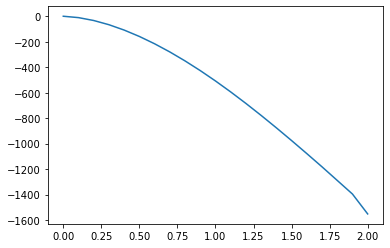

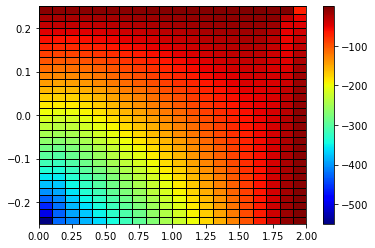

n_gen |  n_eval |   cv (min)   |   cv (avg)   |     fopt     |     favg    
    1 |     100 |  1.02008E+02 |  1.46819E+02 |            - |            -


In [ ]:
nodecon,s,nodecoord,fixed_nodes,numele=TopOpt(20,30,2,0.5,3000,E,nu)

In [1]:
print(s)

NameError: name 's' is not defined

In [23]:
def half_plot(nodecoord,nodecon,numele,E,nu):
    E1=E[0]
    E2=E[1]
    nu1=nu[0]
    nu2=nu[1]
    C1=np.array([[1, nu1, 0], [nu1, 1, 0], [0, 0, (1-nu1)/2]])*(E1/(1-nu1**2))
    C2=np.array([[1, nu2, 0], [nu2, 1, 0], [0, 0, (1-nu2)/2]])*(E2/(1-nu2**2))
    fig2=plt.figure()        #plotting the design
    ax2=plt.gca()

    patches = []
    cm_Sxx=np.empty([numele,])
    cm_Exx=np.empty([numele,])
    r=np.empty([numele,])
    for i in range(numele):
        nodes = nodecon[i,1:5]
        xi = nodecoord[nodes-1,1]
        yi = nodecoord[nodes-1,2]

        xy=np.vstack((xi,yi)).T

        k = Polygon(xy,closed=True,edgecolor='b')
        patches.append(k)
        r[i]=nodecon[i,5]
    p = PatchCollection(patches, cmap='binary', match_original=True)
    p.set_array(r)

    ax2.add_collection(p)
    plt.xlim([0,2])
    plt.ylim([-0.25,0.25])

    # divider = make_axes_locatable(ax2)
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    fig2.colorbar(p,ax=ax2)

    plt.show() 

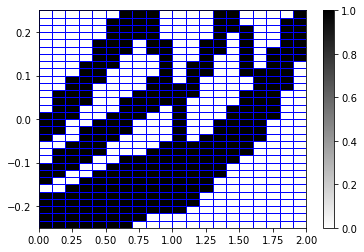

In [24]:
half_plot(nodecoord,nodecon,numele,E,nu)

In [25]:
def full_plot(nodecoord,nodecon,numele,E,nu,nelx,nely,lx,ly):
    c=np.empty(numele,dtype='int')
    c[:numele]=nodecon[:,5]
    c1=np.flipud(c)
    c_2d=np.reshape(c1,(nely,nelx))

    res_2d=np.fliplr(c_2d)

    res= res_2d.flatten()
    final=np.empty(2*numele,dtype='int')
    final[:numele]=nodecon[:,5]
    final[numele:2*numele]=res.astype('int')
    temp_cord=coordinates(nelx,2*nely,lx,ly)
    tempcon = connectivity(nelx,2*nely)
    fig2=plt.figure()        #plotting the design
    ax2=plt.gca()

    patches = []

    r=np.empty([2*numele,])
    for i in range(2*numele):
        nodes = tempcon[i,1:5]
        xi = temp_cord[nodes-1,1]
        yi = temp_cord[nodes-1,2]
        xy=np.vstack((xi,yi)).T

        k = Polygon(xy,closed=True,edgecolor='b')
        patches.append(k)
        r[i]=final[i]
    p = PatchCollection(patches, cmap='binary', match_original=True)
    p.set_array(r)

    ax2.add_collection(p)
    plt.xlim([0,2])
    plt.ylim([-0.5,0.5])

    # divider = make_axes_locatable(ax2)
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    fig2.colorbar(p,ax=ax2)

    plt.show() 

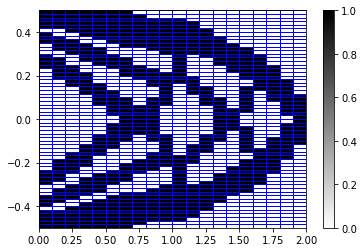

In [27]:
full_plot(nodecoord,nodecon,numele,E,nu,20,30,2,1)